In [1]:
import roboticstoolbox as rtb
from IPython.core.display import SVG

We will load a model for a simple Y-shaped planar robot.  Check out the source code to see how the model was constructed using `ELink` and `ERobot` classes.

In [2]:
robot = rtb.models.ETS.Planar_Y()
print(robot)

┌───┬────────┬────────┬───────┬────────────────┐
│id │  link  │ parent │ joint │      ETS       │
├───┼────────┼────────┼───────┼────────────────┤
│ 0 │  link0 │      - │       │ Rz(q0)         │
│ 1 │  link1 │  link0 │  None │ tx(1) * Rz(q1) │
│ 2 │ link2a │  link1 │  None │ tx(1) * Rz(q2) │
│ 3 │ link3a │ link2a │  None │ tx(1) * Rz(q3) │
│ 4 │ link2b │  link1 │  None │ tx(1) * Rz(q4) │
│ 5 │ link3b │ link2b │  None │ tx(1) * Rz(q5) │
│ 6 │   @eea │ link3a │  None │ tz(1)          │
│ 7 │   @eeb │ link3b │  None │ tz(1)          │
└───┴────────┴────────┴───────┴────────────────┘

┌─────┬─────┬─────┬──────┬─────┬──────┬─────┐
│name │ q0  │ q1  │ q2   │ q3  │ q4   │ q5  │
├─────┼─────┼─────┼──────┼─────┼──────┼─────┤
│  qz │  0° │  0° │  0°  │  0° │  0°  │  0° │
│  qy │  0° │  0° │  45° │  0° │ -45° │  0° │
└─────┴─────┴─────┴──────┴─────┴──────┴─────┘



From the displayed table we see that this robot has two end-effectors, indicated by the links shown in blue and prefixed with the @ symbol.

We can easily create a graphical representation of the  turn the robot description into a [GraphViz dotfile](https://graphviz.org)


In [3]:
robot.dotfile('planar_y.dot')

which writes a file in the current folder.  We then render it to SVG format and [load and display it](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=svg#IPython.display.SVG)

]2;C02D8125PN78:/Users/corkep/code/robotics-toolbox-python/notebooks]1;C02D8125PN78

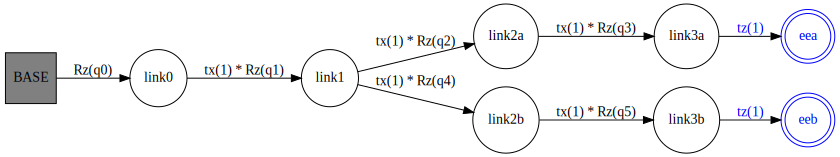

In [4]:
!dot -Tsvg planar_y.dot -x > planar_y.svg
SVG(filename='planar_y.svg')

The fixed base of the robot is shown as the dark grey node.  Link reference frames are shown by circles and the edges are marked with the elementary transform sequences that define the relative poses of the link frames.  End-effector nodes are marked by a blue double circle.

The ETS transforms in black indicate the joints, and they contain the five joint angles `q0` to `q5`.  The assignement of joint numbers is arbitrary and decided by the creator of the robot model.  All operations such as forward kinematics or Jacobians that accept a joint angle vector, organize it as `[q0, q1, q2, q3, q4 q5]`.

Fixed joints  are shown in blue. 

The forward kinematics is quite straightforward, but we must specify which end-effector we are interested in

In [5]:
robot.fkine(robot.qz, endlink='eea')

SE3:   1           0           0           3            
       0           1           0           0            
       0           0           1           1            
       0           0           0           1            
    

which is exactly the same as the pose of the second branch

In [6]:
robot.fkine(robot.qz, endlink='eeb')

SE3:   1           0           0           3            
       0           1           0           0            
       0           0           1           1            
       0           0           0           1            
    

In a similar fashion we can also compute the Jacobian, in this case as a $6 \times 4$ matrix

In [7]:
robot.jacob0(robot.qz, endlink='eea')

array([[0., 0., 0., 0.],
       [3., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.]])

We can generate an ETS for the bottom-branch of the robot

In [8]:
p = robot.ets(end='eeb')
p

Rz(q0) * tx(1) * Rz(q1) * tx(1) * Rz(q4) * tx(1) * Rz(q5) * tz(1)

and we could easily turn this into an unbranched robot represented by an `ERobot` instance

In [9]:
r = rtb.ERobot(p, checkjindex=False)
print(r)

┌───┬───────┬────────┬───────┬────────────────┐
│id │ link  │ parent │ joint │      ETS       │
├───┼───────┼────────┼───────┼────────────────┤
│ 0 │ link0 │      - │       │ Rz(q0)         │
│ 1 │ link1 │  link0 │  None │ tx(1) * Rz(q1) │
│ 2 │ link2 │  link1 │  None │ tx(1) * Rz(q4) │
│ 3 │ link3 │  link2 │  None │ tx(1) * Rz(q5) │
│ 4 │   @ee │  link3 │  None │ tz(1)          │
└───┴───────┴────────┴───────┴────────────────┘



This robot has 5 links but only 4 joint angles which are inherited from the original branched robot: `q0`, `q1`, `q4` and `q5`.  If invoking its `fkine` method you must pass in a vector with at least 6 elements, but only 4 elements will be used.

We can also find the transformation between any two links in the robot.  In this case, from one end effector to the other, from link eea to link eeb

In [10]:
p = robot.ets(start='eea', end='eeb')
p

tz(-1) * Rz(-q3) * tx(-1) * Rz(-q2) * tx(-1) * tx(1) * Rz(q4) * tx(1) * Rz(q5) * tz(1)

which is expressed as an ETS.  Note that it is not in minimal form and the terms in the middle `tx(-1) * tx(1)` cancel out.  We can precompile the constants which will take care of this for us

In [11]:
p.compile()

C0 * Rz(-q3) * C1 * Rz(-q2) * Rz(q4) * C2 * Rz(q5) * C3

# Graph display variations

This robot is entirely revolute, but we can visualize the joint types in the graphical representation by using the `jtype` keyword argument

]2;C02D8125PN78:/Users/corkep/code/robotics-toolbox-python/notebooks]1;C02D8125PN78

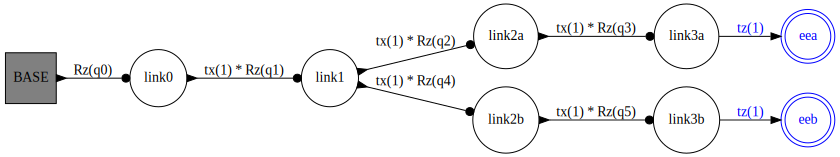

In [15]:
robot.dotfile('planar_y.dot', jtype=True)
!dot -Tsvg planar_y.dot > planar_y.svg
SVG(filename='planar_y.svg')

and the input to a link frame is a black dot if it is preceded by a revolute joint, and a black box if it  preceded by a prismatic joint.

We can also highlight the ETS by placing them in boxes, rather than being just edge labels, using the `etsbox` option

]2;C02D8125PN78:/Users/corkep/code/robotics-toolbox-python/notebooks]1;C02D8125PN78

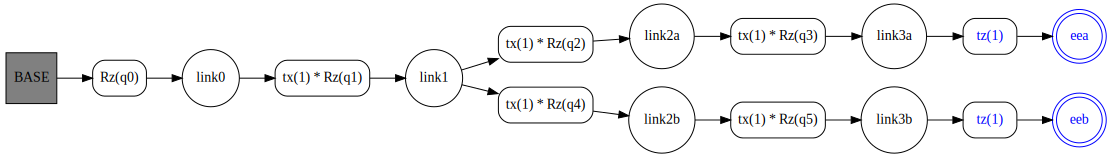

In [13]:
robot.dotfile('planar_y.dot', etsbox=True)
!dot -Tsvg planar_y.dot > planar_y.svg
SVG(filename='planar_y.svg')

## PR2 model

The PR2 is a very complex branched robot with nearly 90 links

Caster is an invalid color name, using default color
Wheel_l is an invalid color name, using default color
Wheel_r is an invalid color name, using default color
Caster is an invalid color name, using default color
Wheel_l is an invalid color name, using default color
Wheel_r is an invalid color name, using default color
Caster is an invalid color name, using default color
Wheel_l is an invalid color name, using default color
Wheel_r is an invalid color name, using default color
Caster is an invalid color name, using default color
Wheel_l is an invalid color name, using default color
Wheel_r is an invalid color name, using default color
Grey2 is an invalid color name, using default color
RollLinks is an invalid color name, using default color
RollLinks is an invalid color name, using default color
RollLinks is an invalid color name, using default color
RollLinks is an invalid color name, using default color
RollLinks is an invalid color name, using default color
RollLinks is an invalid 

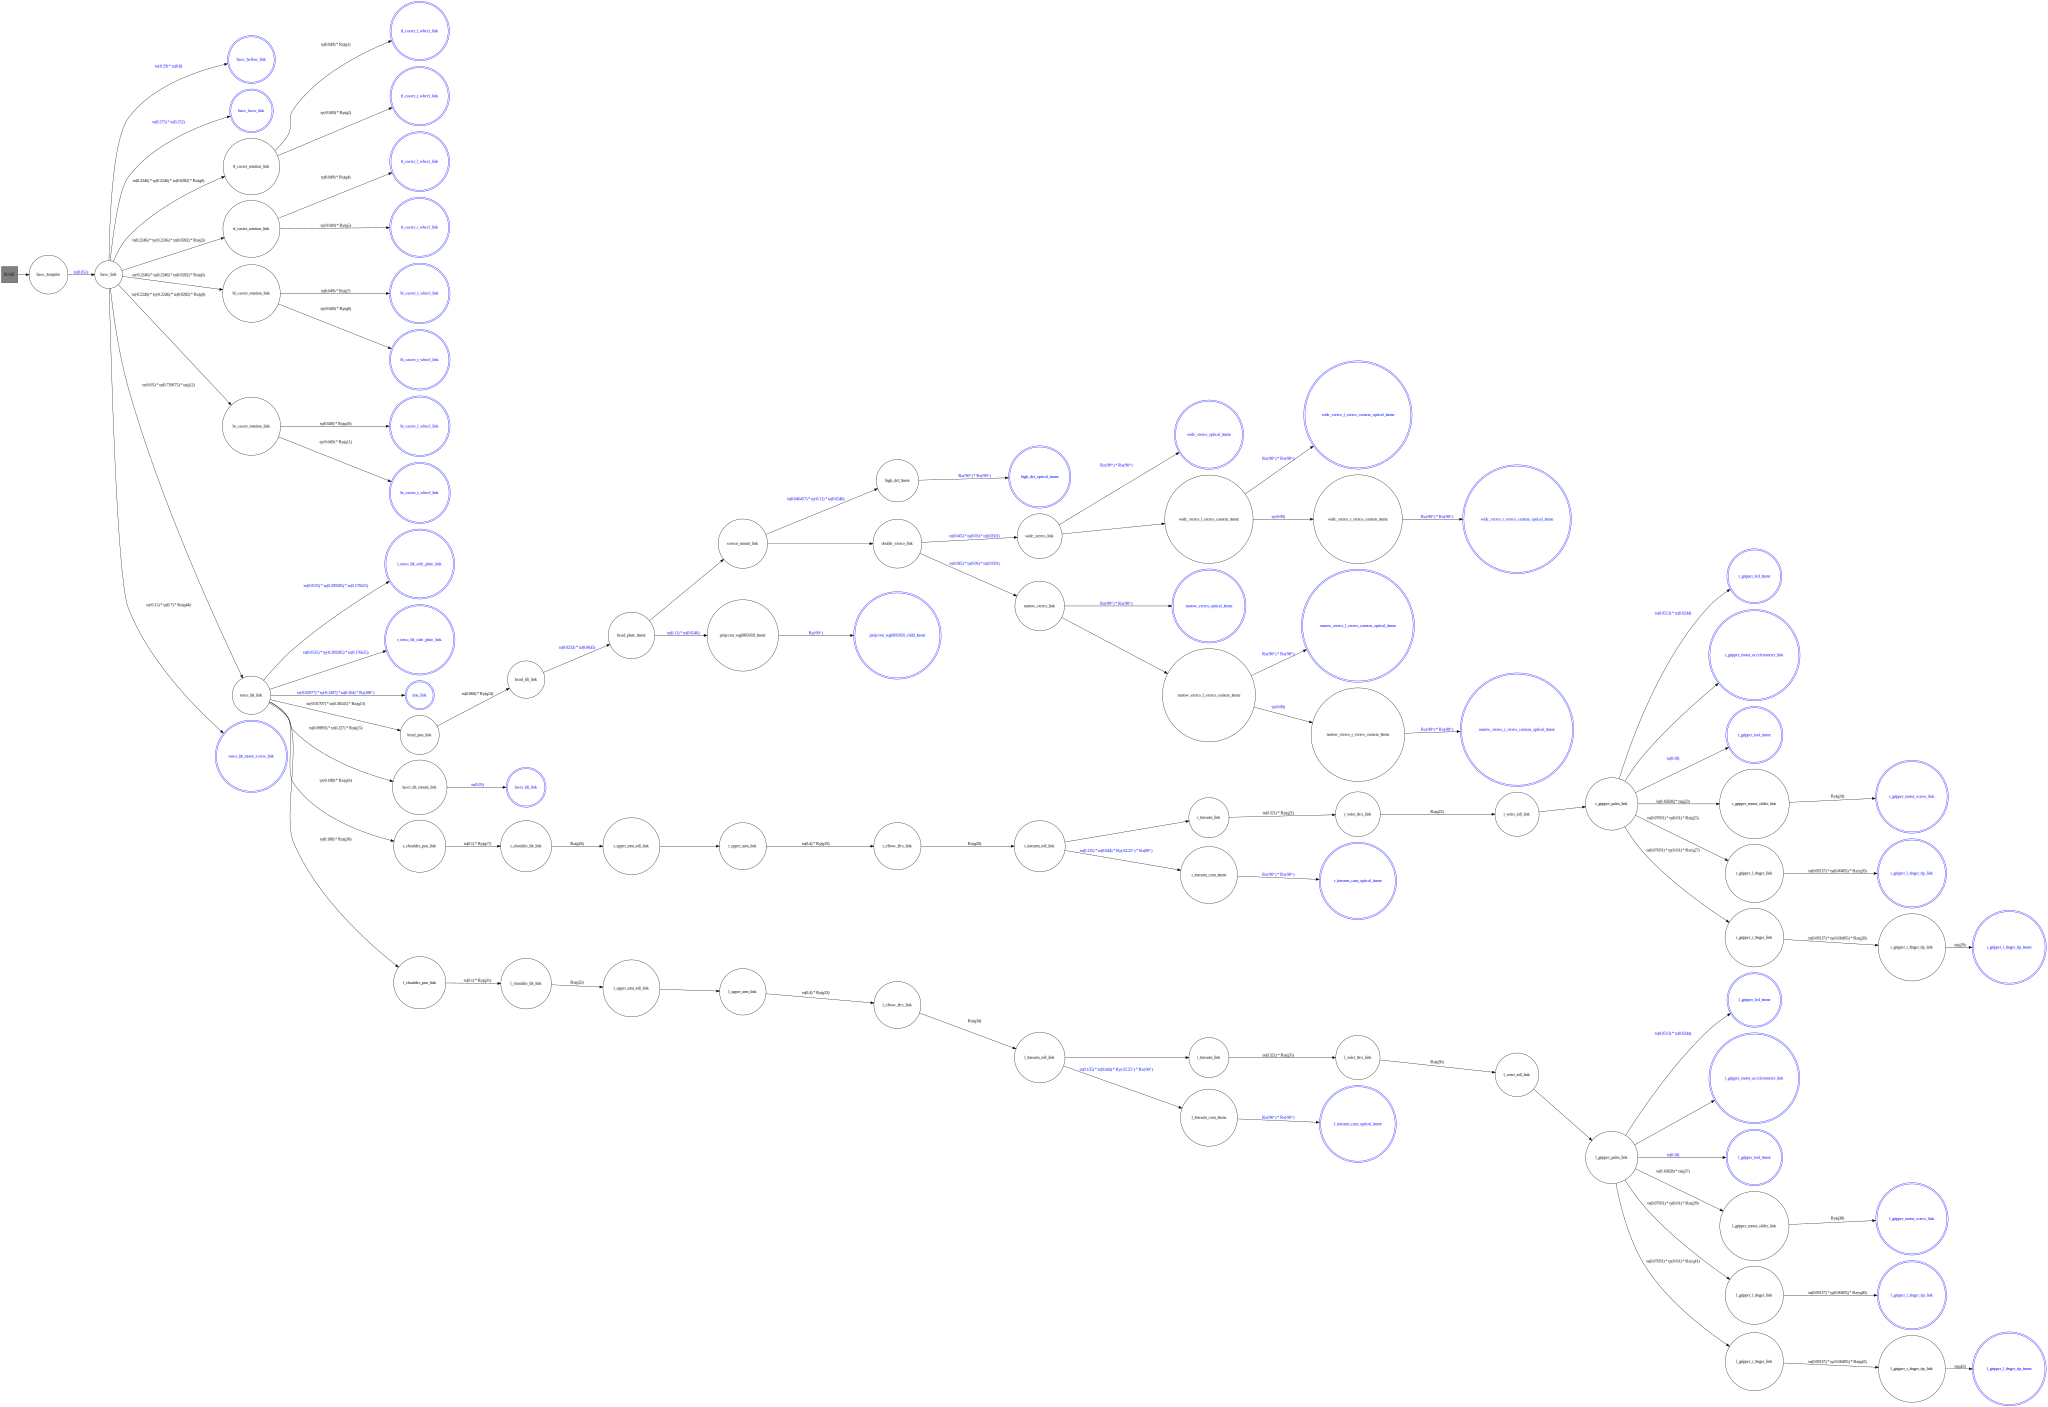

In [14]:
pr2 = rtb.models.URDF.PR2()
pr2.dotfile('pr2.dot')
!dot -Tsvg pr2.dot > pr2.svg
SVG(filename='pr2.svg')